# Курсовой проект по АВС

## Тема проекта

` Перемножение матриц с использованием технологии Cuda`

## Описание проекта

`Разобраться и реализовать несколько разных алгоритмов умножения и сравнить их производительность`


# Пояснительная записка


## Содержание

1. Перемножение матриц по частям
2. Перемножение матриц с использованием алгоритма Strassen'a


## 1. Перемножение матриц по частям

### Идея

Для матриц помещающихся в глобальную память GPU можно сразу вычислить их произведение с использованием _cuBLAS_ (стандартный функция перемножения матриц в Cuda)/

В обратном случае можно разбить матрицу на блоки, перемножить их, а затем собрать воедино.

![](https://raw.githubusercontent.com/zpzim/MSplitGEMM/master/Readme/blockMult.jpg)


### Алгоритм


Пусть есть две матрицы _A_ & _B_ размерами `n x k` & `k x m`.

Разобьём матрицу _A_ на $\lceil \frac{n}{a} \rceil$ частей, где _а_ - количество строк в каждой подматрице. Если для $\lceil \frac{n}{a} \rceil$ой матрицы не хватило строк, то дозаполняем их нулями. 

Таким образом получаем $\lceil \frac{n}{a} \rceil$ матриц размером `a x k` для матрицы _А_ (обозначим $A_{i}$).

Таким же образом разбиваем матрицу _B_, но не по строкам, а по столбцам, т.е. матрица _B_ разбивается на $\lceil \frac{m}{b} \rceil$ подматриц (обозначим $B_{j}$), где _b_ - количество столбцов в каждой подматрице. 

Получаем ещё $\lceil \frac{m}{b} \rceil$ матриц размером `k x b` для матрицы _В_.

Теперь если перемножить матрицы $A_{i} \cdot B_{j}$, то таким образом итоговая матрица будет являться подматрицей ответа с началом в элементе $[a \cdot i, b \cdot j]$, то есть заполнит подматрицу $[a \cdot i, b \cdot j], [(a + 1) \cdot i, b \cdot j], [a \cdot i, (b + 1) \cdot j], [(a + 1) \cdot i, (b + 1) \cdot j]]$


#### Потребление памяти

```cpp
GPU memory usage = (k * (a + b) + a * b) * sizeof(type)
```

Теперь, изменяя _a_ & _b_, можно изменять необходимый объём памяти на GPU.

#### Как можно использовать

Частный случай такого алгоритма, когда матрица _В_ загружается полностью, а матрица _А_ берётся частями, т.е., например, при чтении из файла.

В таком случае можно поблочно считывать из файла матрицу _А_, храня только одну подматрицу, умножать её на матрицу _В_, получать результат в качестве результата `размер блока` строк в итоговой матрице и сразу же записывать её в файла, чтобы также не занимать место.



## 2. Перемножение матриц с использованием алгоритма Strassen'a

### Идея

Идея, схожая с перемножением матриц по частям, лежит в основе работы алгоритма _Strassen'a_. Здесь нужно будет перемножать матрицы `2 x 2`.

Данный алгоритм может перемножать матрицы за время $O(n^{\log^{7}_{2}})$ или $O(n^{2.81})$ (кстати, самый быстрые известный алгоритм может перемножать матрицы за время $O(n^{2.38})$).

Начнём с простого.

Разобьём матрицы _А_ и _В_ на 4 равные части (сами матрицы должны быть квадратные и одинаковой размерности), таким же образом представим матрицу _С_. Получим что-то такое - 3 матрицы размером `2 x 2`:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/41c6337190684aff7b69f124226d6e62d79ebca5)

Тогда, чтобы вычислить матрицу _С_ можно воспользоваться формулами для умножения матриц:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/8d91fa79d27697a5c6551698c1a83a3d5837c57b)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a08bea24eec9422cda82e6e04af1d96fc6822038)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/7adffe97db091ce8ba231352b3721bbe261985ca)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/8b40ed74cf54465d8e54d09b8492e50689928313)

В таком случае необходимо провести _8 операций умножения и 4 операции сложения_. Причём данные операции умножения мы можем выполнять рекурсивно, используя наш текущий алгоритм, пока размер матрицы > 1 (при матрице размером 1 просто $c = a \cdot b$).

Сложность такого алгоритма следующая: на каждый новый вызов нашего алгоритма проблема уменьшается в 2 раза, но таких уменьшающих операций у нас 8 (сложение можно не учитывать, т.к. это всего $O(n^2)$). Это можно записать следующим образом:

$$T(n) = 8 \cdot T(\frac{n}{2}) + O(n^2)$$

Теперь воспользуемся мастер теоремой:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2f5661cc61a3a08b59ef5b55309cd1e4d4514815)

И получим $a = 8$, $b = 2$, $f(n) = n^2$ - это первый случай, т.е. $\log_{a}{b} = \log_{2}{8} = 3 > 2$, т.е. сложность такого алгоритма _$O(n^3)$_. Никакого выигрыша не получаем.

### Strassen & Winograd

Strassen предложил алгоритм, при котором вместо 8 умножений необходимо сделать всего 7, но количество сложений / вычитаний увеличится до 18.

Свой вариант для решение данной задачи предложил также и Winograd. В его варианте данного алгоритма необходимо провести 7 операций умножения и 15 операций сложения / вычитания, а это немного быстрее, чем у Strassen'a.

В таком случае изменяется формула:

$$T(n) = 7 \cdot T(\frac{n}{2}) + O(n^2)$$

В мастер теореме получаем $a = 7$, $b = 2$, $f(n) = n^2$, это первый случай - $\log_{a}{b} = \log_{2}{7} = 2.81 > 2$, т.е. сложность такого алгоритма _$O(n^{2.81})$_. Это уже поинтереснее, чем $O(n^3)$.

### Сложность

Сложность данного алгоритма: $O(n^{\log_{2}{7}})$.

### Формулы

Strassen предложил вычислять результат произведения матриц следующим образом:

![](./images/strassen_algo.jpg)

В свою очередь Winograd предложил так:

![](./images/winograd_algo.jpg)


### Реализация

#### Одноуровневая

Когда больше не уменьшается размер матрицы, считая, что текущий размер нас удовлетворяет и мы готовы потратить на умножение $O(n^3)$ операций.

![](./images/strassen_onelevel.jpg)

![](./images/winograd_onelevel.jpg)

#### Рекурсивная

Когда размер матрицы стоит ещё уменьшить, потому что тратить на умножение $O(n^3)$ дорого.

![](./images/strassen_recursion.jpg)

![](./images/winograd_recursion.jpg)


### Параметры

В реализации рассматривалось две версии:
+ одноуровневая
+ рекурсивная

Переход от рекурсивной к одноуровневой как раз и зависит от параметров.

Время работы функций в зависимости от параметров (среднее значение на 10 итерациях, матриц размером `128 x 128`):
+ для Strassen'a - это количество рекурсивных вызовов
+ для умножения по частям - это размер подматриц


![](./images/strassen_time.jpg)


Как видно из времени работы - алгоритм Strassen'a работает медленнее остальных. Это нормально, потому что матрица маленького размера.

Такие алгоритмы работают медленее на маленьких матрицах, потому что у них большая константа.

![](./images/parts_mm.jpg)

Заметно, что с уменьшением размеров матриц время работы увеличивается.

## Сравним перемножение матриц
1. обычным способом ($O(n^3)$)
2. с использованием алгоритма Strassen'a ($O(n^{\log_{2}{7}})$)

Замерения проводились на CPU _i5-8365_.

Рассматривались матрицы размерами $2^i,\ i = [1, 10]$.

Для каждой матрицы и метода проводилось 100 итераций, а зачем бралось среднее арифметическое время работы.

In [1]:
import numpy as np
import prettytable as pt
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### Прочитаем логи

In [2]:
strassen_algo = {}
naive_algo = {}
matrices_size = []


with open("console_log.txt") as f:
    for size in f:
        curr_size = int(size)
        matrices_size.append(curr_size)
        
        strassen_algo_time = float(f.readline().split()[1])
        naive_algo_time = float(f.readline().split()[1])
        
        strassen_algo[curr_size] = round(strassen_algo_time / 1000, 4)
        naive_algo[curr_size] = round(naive_algo_time / 1000, 4)

### Визуализируем данные в виде таблицы

In [3]:
t = pt.PrettyTable()

t.field_names = ['Matrix size', 'Naive algo time (ms)', 'Strassen algo time (ms)']

for size in matrices_size:
    t.add_row([size, naive_algo[size], strassen_algo[size]])

print(t)

+-------------+----------------------+-------------------------+
| Matrix size | Naive algo time (ms) | Strassen algo time (ms) |
+-------------+----------------------+-------------------------+
|      2      |        0.0001        |          0.0003         |
|      4      |        0.0008        |          0.0011         |
|      8      |        0.0053        |          0.0067         |
|      16     |        0.0318        |          0.0458         |
|      32     |        0.1512        |          0.2052         |
|      64     |        1.131         |          1.2524         |
|     128     |        9.3869        |          7.6067         |
|     256     |        98.562        |         53.5292         |
|     512     |       870.147        |         394.859         |
|     1024    |       28809.7        |         2795.72         |
+-------------+----------------------+-------------------------+


### Визуализируем данные в виде графика

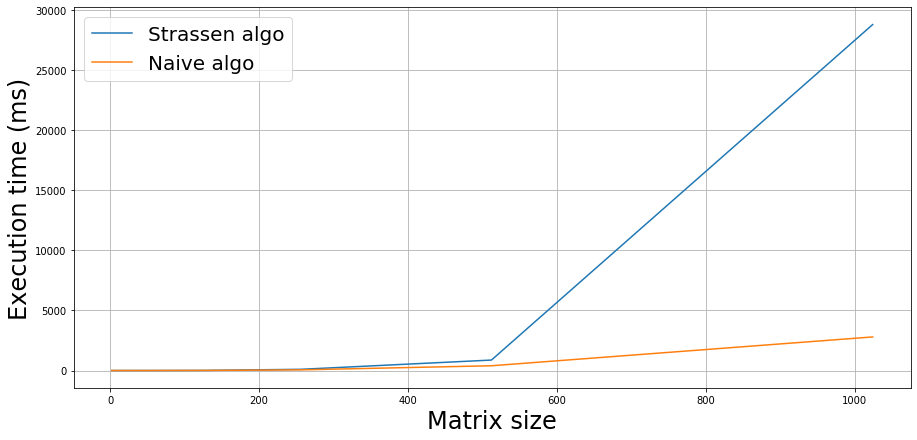

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(matrices_size, list(naive_algo.values()), label='Strassen algo')
plt.plot(matrices_size, list(strassen_algo.values()), label='Naive algo')

plt.ylabel("Execution time (ms)", fontsize=24)
plt.xlabel("Matrix size", fontsize=24)
plt.legend(fontsize=20)
plt.grid()
plt.show()

### Посмотрим как изменяется коэффициент ускорения (времени работы)

$$
\frac{Strassen\ algo\ time}{Naive\ algo\ time}
$$

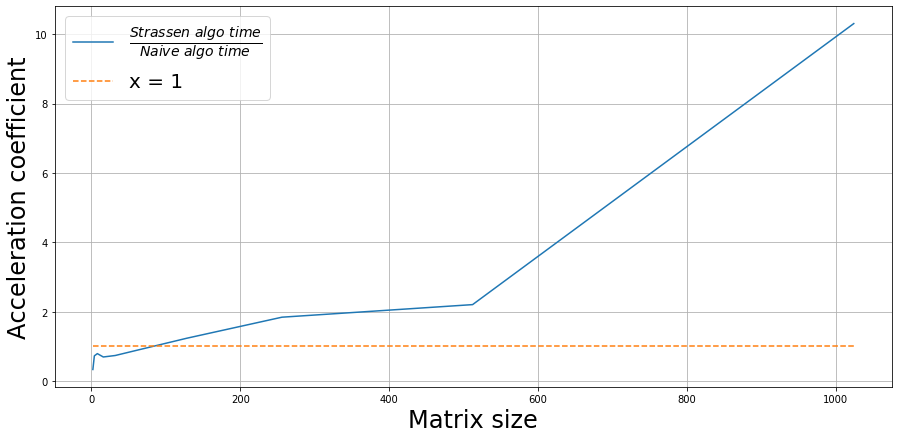

In [9]:
acceleration = [naive_algo[i] / strassen_algo[i] for i in matrices_size]

plt.figure(figsize=(15, 7))
plt.plot(matrices_size, acceleration, 
         label=r'$\frac{Strassen\ algo\ time}{Naive\ algo\ time}$')
plt.plot(matrices_size, [1] * len(matrices_size), '--', label='x = 1')

plt.ylabel('Acceleration coefficient', fontsize=24)
plt.xlabel('Matrix size', fontsize=24)

plt.legend(fontsize=20)
plt.grid()
plt.show()

### Выводы

Из графика (для ускорения работы) можно сделать вывод, что он является степенной функцией.

Также можно заметить, что для маленьких размерностей наивный алгоритм быстрее. Всё потому что константа перед алгоритмом Strassen'a гораздо больше, чем перед наивным (в первом 7 умножений и 15 сложений матриц (для алгоритма Winograd'a), а во втором 8 умножений, но 4 сложения матриц).


## Литература

1. https://staff.kfupm.edu.sa/ics/ahkhan/Resources/Papers/Numerical%20Algorithms/strassen_gpu.pdf
2. https://www.youtube.com/watch?v=0oJyNmEbS4w